# Loan Approval Prediction Using Machine Learning

# Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer

# Loading the dataset

In [2]:
df = pd.read_csv('C:/Users/ASUS/Desktop/Power BI Practice/loan_data.csv')
df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2.0,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0.0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3.0,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2.0,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1.0,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


# Basic data exploration

In [3]:
print(df.info())   # Display the data types and missing values
print(df.describe())   # Show basic statistics of numerical columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            598 non-null    object 
 1   Gender             598 non-null    object 
 2   Married            598 non-null    object 
 3   Dependents         586 non-null    float64
 4   Education          598 non-null    object 
 5   Self_Employed      598 non-null    object 
 6   ApplicantIncome    598 non-null    int64  
 7   CoapplicantIncome  598 non-null    float64
 8   LoanAmount         577 non-null    float64
 9   Loan_Amount_Term   584 non-null    float64
 10  Credit_History     549 non-null    float64
 11  Property_Area      598 non-null    object 
 12  Loan_Status        598 non-null    object 
dtypes: float64(5), int64(1), object(7)
memory usage: 60.9+ KB
None
       Dependents  ApplicantIncome  CoapplicantIncome  LoanAmount  \
count  586.000000       598.000000    

# Handle missing values (if any)

In [4]:
# Fill missing values with median or mode depending on the column type
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median())
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])

df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])

# Feature engineering - Adding log-transformed values for skewed numerical columns

In [5]:
# Log-transform skewed numerical columns to normalize them
df['LoanAmount_log'] = np.log(df['LoanAmount'] + 1)  # Adding 1 to avoid log(0)
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'] + 1)

# Visualizing distributions of numerical features

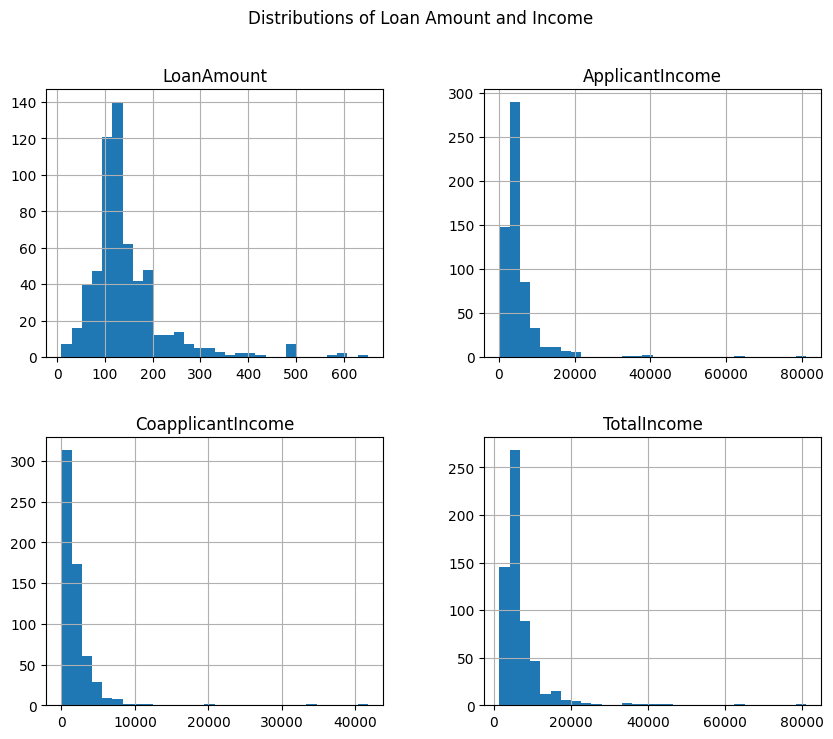

In [6]:
df[['LoanAmount', 'ApplicantIncome', 'CoapplicantIncome', 'TotalIncome']].hist(bins=30, figsize=(10, 8))
plt.suptitle('Distributions of Loan Amount and Income')
plt.show()

# Bar plot of Loan_Status counts to visualize class distribution

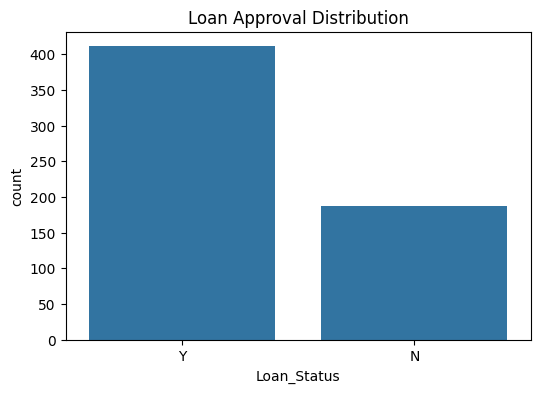

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Loan_Status', data=df)
plt.title('Loan Approval Distribution')
plt.show()

# Correlation heatmap - only for numerical columns

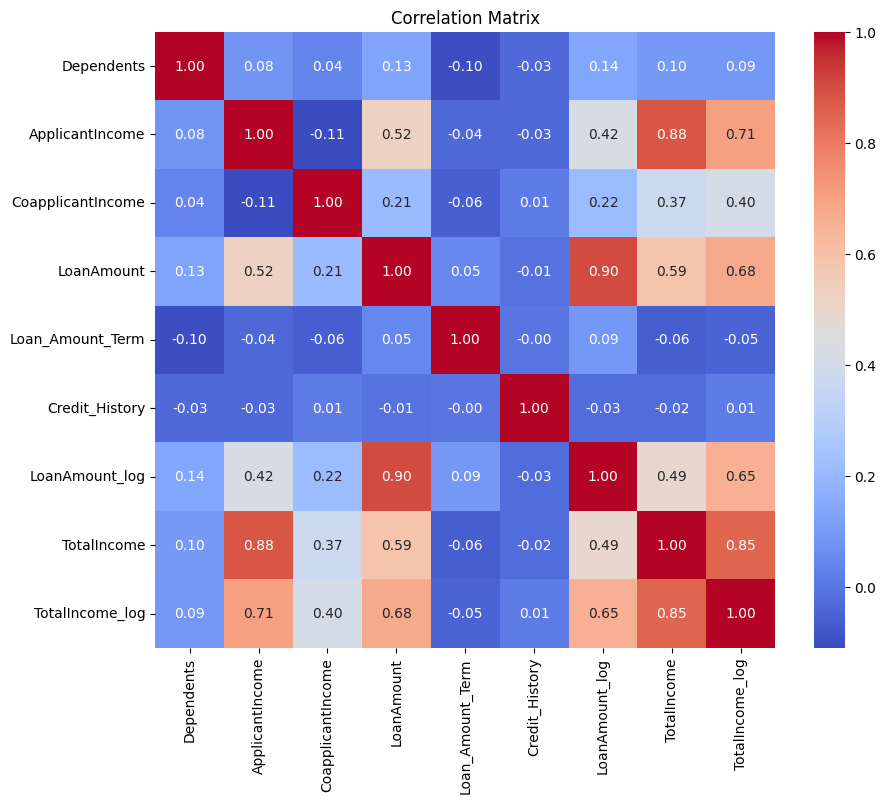

In [8]:
# Correlation analysis of numerical features to identify relationships
plt.figure(figsize=(10, 8))
numerical_df = df.select_dtypes(include=[np.number])   # Select only numerical columns
corr_matrix = numerical_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Encode categorical variables

In [9]:
# Label encode categorical columns
encoder = LabelEncoder()
df['Gender'] = encoder.fit_transform(df['Gender'])
df['Married'] = encoder.fit_transform(df['Married'])
df['Education'] = encoder.fit_transform(df['Education'])
df['Self_Employed'] = encoder.fit_transform(df['Self_Employed'])
df['Property_Area'] = encoder.fit_transform(df['Property_Area'])
df['Loan_Status'] = encoder.fit_transform(df['Loan_Status'])  # Target variable

# Replace '3+' in Dependents with 3 and convert to integer type
df['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)

# Prepare the data for modeling

In [10]:
# Select features and target variable for modeling
X = df[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'LoanAmount_log', 
        'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'TotalIncome_log']]
y = df['Loan_Status']

# Split the data into training and testing sets

In [11]:
# Use train_test_split to create training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model training - RandomForestClassifier

In [12]:
# Train a Random Forest classifier on the training data
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Make predictions and evaluate the model

In [13]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')   # Printing accuracy of the model

Accuracy: 77.22%


# Display the confusion matrix and classification report

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', classification_report(y_test, y_pred))

Confusion Matrix:
 [[ 25  31]
 [ 10 114]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.45      0.55        56
           1       0.79      0.92      0.85       124

    accuracy                           0.77       180
   macro avg       0.75      0.68      0.70       180
weighted avg       0.76      0.77      0.75       180



# Visualize the confusion matrix

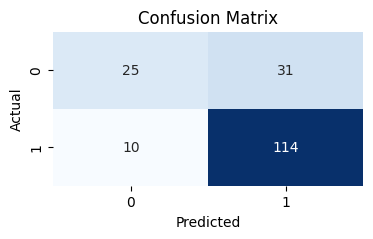

In [15]:
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Handle class imbalance using SMOTE

In [16]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Train an XGBoost model for comparison

In [17]:
model_xgb = XGBClassifier(random_state=42)  # Removed use_label_encoder
model_xgb.fit(X_res, y_res)
y_pred_xgb = model_xgb.predict(X_test)

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {xgb_accuracy * 100:.2f}%')

XGBoost Accuracy: 100.00%


In [18]:
# Display confusion matrix and classification report for XGBoost
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print('Confusion Matrix (XGBoost):\n', conf_matrix_xgb)
print('Classification Report (XGBoost):\n', classification_report(y_test, y_pred_xgb))

Confusion Matrix (XGBoost):
 [[ 56   0]
 [  0 124]]
Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00       124

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



# Visualize the confusion matrix for XGBoost

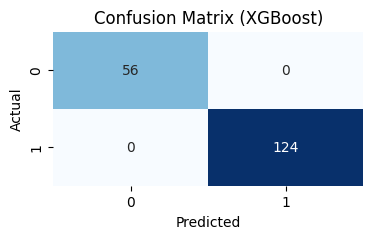

In [19]:
plt.figure(figsize=(4, 2))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance

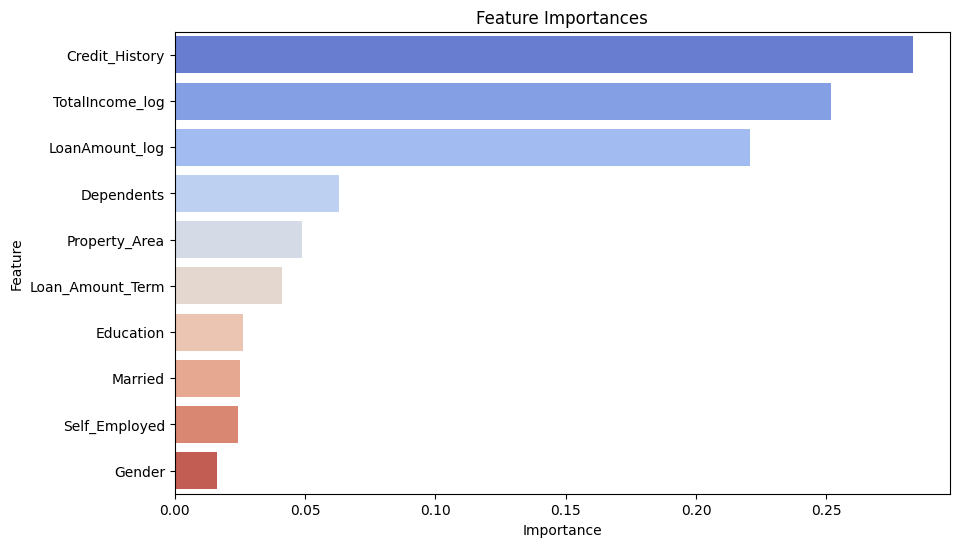

In [20]:
# Visualize the importance of different features used in the Random Forest model
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', palette='coolwarm', dodge=False, legend=False)
plt.title('Feature Importances')
plt.show()